# 6.0 — LSTM pour la prévision de volatilité (σ₁ et vol5f)


**Explication :**  
1) On essaie d’importer KneeLocator (librairie *kneed*) pour la détection automatique du “coude” (utile dans certaines étapes de calibration ou de choix d’hyperparamètres).  

**Pourquoi nous avons fait cela :**  
1) L’import de KneeLocator est optionnel : il permet d’automatiser la détection d’un point optimal (par ex. taille de cluster, nombre d’itérations) mais le code reste robuste si la librairie n’est pas disponible.  



In [2]:


from __future__ import annotations
from pathlib import Path
import argparse, json, math, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Optional elbow detection
try:
    from kneed import KneeLocator
    HAS_KNEE = True
except Exception:
    HAS_KNEE = False


### 6.1 Paramètres par défaut & constantes


In [3]:
PROC_DIR = Path("data/processed")
OUT_DIR  = Path("data/models/lstm")
TRADING_DAYS = 252


### 6.2 Fonctions utilitaires (reproductibilité, device, test DM)

**Explication :**  
1) "set_seed" fixe les graines aléatoires pour Python, NumPy et PyTorch afin d’assurer la reproductibilité des expériences.  
2) "to_device" envoie les tenseurs ou listes/tuples de tenseurs sur l’appareil spécifié.  
3) "dm_test_mse" implémente une version simplifiée du test de Diebold–Mariano en utilisant la MSE comme fonction de perte et en supposant des erreurs iid.

**Pourquoi nous avons fait cela :**  
1) La reproductibilité est essentielle en Deep Learning pour comparer équitablement les modèles et valider les résultats.  
2) Le transfert automatique vers le bon device simplifie l’écriture du code et permet d’exploiter le GPU sans réécrire les fonctions.  
3) Le test DM fournit une comparaison statistique simple entre deux modèles de prévision, garantissant que les différences de performance sont significatives et pas dues au hasard.  



In [4]:
def set_seed(seed: int = 42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    try:
        torch.use_deterministic_algorithms(True)
    except Exception:
        pass
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def to_device(x, device):
    if isinstance(x, (list, tuple)):
        return [to_device(t, device) for t in x]
    return x.to(device)

def dm_test_mse(y_true: np.ndarray, y1: np.ndarray, y2: np.ndarray) -> tuple[float, float]:
    """
    Simple Diebold-Mariano test with MSE loss under iid errors (approx).
    Returns (DM_stat ~ N(0,1), p_value).
    """
    from math import sqrt
    from scipy.stats import norm
    e1 = (y_true - y1)**2
    e2 = (y_true - y2)**2
    d  = e1 - e2
    dm = d.mean() / (d.std(ddof=1) / sqrt(len(d)))
    p  = 2*(1 - norm.cdf(abs(dm)))
    return float(dm), float(p)


### 6.3 Construction des features (cibles et variables explicatives)

**Explication :**  
1) "load_base_frame" charge le jeu de données de base contenant les rendements journaliers, les volatilités et éventuellement le VIX.  
2) "build_targets" crée les cibles de prévision :  
   - "target_sigma1" : volatilité réalisée à 1 jour (annualisée).  
   - "target_vol5f" : volatilité réalisée sur 5 jours futurs (annualisée).  
3) "add_inputs_basic" construit un jeu de variables minimal (rendements clampés, EWM, vol réalisée 21j).  
4) "add_inputs_enriched" enrichit les features avec des lags de rendements au carré, des lags d’EWM et, si disponibles, des variables liées au VIX (niveau et variations).  
5) "assemble_feature_table" assemble la table finale en fusionnant les inputs et les targets, puis supprime les lignes invalides.  

**Pourquoi nous avons fait cela :**  
1) Créer des cibles (σ1, vol5f) permet d’entraîner des modèles supervisés adaptés aux horizons de prévision souhaités.  
2) Disposer de plusieurs versions des features permet de comparer la performance des modèles selon la richesse des informations disponibles.  
3) L’utilisation des lags respecte la causalité temporelle : à la date t, seules les informations antérieures ou contemporaines sont utilisées.  
4) Le nettoyage des NaN garantit un dataset exploitable et cohérent pour l’entraînement des modèles.  


In [5]:
def load_base_frame() -> pd.DataFrame:
    df = pd.read_parquet(PROC_DIR / "spx_index_features.parquet").sort_values("date").reset_index(drop=True)
    return df

def build_targets(df: pd.DataFrame) -> pd.DataFrame:
    feats = pd.DataFrame({"date": df["date"].values})
    sig1 = (df["ret_d"].astype(float)**2).shift(-1).pow(0.5) * math.sqrt(TRADING_DAYS)
    fwd_mat = np.column_stack([df["ret_d"].astype(float).shift(-k).values for k in range(1, 6)])
    mask = ~np.isnan(fwd_mat).any(axis=1)
    vol5 = np.full(len(df), np.nan, dtype=float)
    vol5[mask] = np.sqrt(np.mean(np.square(fwd_mat[mask]), axis=1)) * math.sqrt(TRADING_DAYS)

    feats["target_sigma1"] = sig1.values
    feats["target_vol5f"]  = vol5
    return feats

def add_inputs_basic(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame({
        "date": df["date"].values,
        "ret":  df["ret_d_clamped"].astype(float).values,
        "ewm":  df["vol_ewm_094"].astype(float).values,   
        "real21": df["vol21"].astype(float).values        
    })
    return out

def add_inputs_enriched(df: pd.DataFrame, max_lag: int = 10) -> pd.DataFrame:
    """
    Enriched feature set (no leakage): ret, r2 lags, EWM + lags, optional VIX + lags.
    All lags are backward-looking: shift(k) so that at index t we only use info <= t-k.
    """
    out = add_inputs_basic(df)
    r2 = (df["ret_d"].astype(float)**2).values
    out["r2"] = r2

    for k in (1, 5, 10):
        out[f"r2_l{k}"]  = pd.Series(r2).shift(k)
        out[f"ewm_l{k}"] = pd.Series(df["vol_ewm_094"].astype(float).values).shift(k)

    for k in range(2, min(max_lag, 10)+1):
        if k not in (5, 10):
            out[f"r2_l{k}"]  = pd.Series(r2).shift(k)
            out[f"ewm_l{k}"] = pd.Series(df["vol_ewm_094"].astype(float).values).shift(k)

    vix_cols = [c for c in df.columns if "vix" in c.lower()]
    if vix_cols:
        if "vix_close" in df.columns:
            vix_lvl = df["vix_close"].astype(float).values
        else:
            vix_lvl = df[vix_cols[0]].astype(float).values
        out["vix"] = vix_lvl
        out["dvix"] = pd.Series(vix_lvl).diff()

        for k in (1, 5, 10):
            out[f"vix_l{k}"]  = pd.Series(vix_lvl).shift(k)
            out[f"dvix_l{k}"] = pd.Series(out["dvix"]).shift(k)

    return out

def assemble_feature_table(args) -> pd.DataFrame:
    base = load_base_frame()
    tgt  = build_targets(base)
    if args.features == "basic":
        xdf = add_inputs_basic(base)
    else:
        xdf = add_inputs_enriched(base, max_lag=args.max_lag)

    df = xdf.merge(tgt, on="date", how="inner")
    before = len(df)
    df = df.dropna().reset_index(drop=True)
    after = len(df)
    print(f"[prep] rows kept: {after}/{before} ({after/before:.1%}) after lag/target alignment.")
    return df


### 6.4 Classe SeqBuilder : préparation du dataset séquentiel

**Explication :**  
1) "SeqBuilder" prend en entrée un DataFrame contenant les features et les cibles.  
2) Les features ("X") sont toutes les colonnes sauf la date et les colonnes de target.  
3) Les cibles ("y") sont transformées en pourcentage (×100), puis éventuellement passées au log selon l’argument "target_scale".  
4) "time_split" découpe les indices en trois ensembles : train, validation et test (par ratios).  
5) "make_tensors" standardise les features sur la base de l’échantillon d’entraînement, puis construit les séquences de longueur "lookback" pour alimenter un réseau LSTM.  
6) Les jeux de données sont convertis en "TensorDataset" PyTorch pour un usage direct avec les "DataLoader".  

**Pourquoi nous avons fait cela :**  
1) Les modèles LSTM nécessitent des séquences temporelles : "SeqBuilder" automatise cette construction à partir des features historiques.  
2) La standardisation des inputs uniquement sur le train évite toute fuite d’information.  
3) La transformation des cibles (pourcentage, log) rend l’apprentissage plus stable et protège contre les valeurs extrêmes.  
4) Le découpage temporel (train/val/test) respecte la chronologie et permet une évaluation réaliste des performances.  


In [6]:
class SeqBuilder:
    def __init__(self, df: pd.DataFrame, lookback: int, target_name: str, target_scale: str):
        """
        df: includes input features + target columns (annualized in 0.x)
        target transformed to % then (optionally) log
        """
        self.lookback = lookback
        self.target_name = target_name
        self.target_scale = target_scale

        self.dates  = df["date"].values
        target_cols = {"target_sigma1", "target_vol5f"}
        feat_cols = [c for c in df.columns if c not in (["date"] + list(target_cols))]
        self.feat_cols = feat_cols

        X = df[feat_cols].values.astype(np.float32)
        y_raw = (df[target_name].values.astype(np.float32) * 100.0)

        self.X_full = X
        self.y_full = y_raw

    def time_split(self, train_ratio=0.7, val_ratio=0.15):
        N = len(self.y_full)
        n_tr = int(N * train_ratio)
        n_va = int(N * val_ratio)
        idx_tr = np.arange(0, n_tr)
        idx_va = np.arange(n_tr, n_tr + n_va)
        idx_te = np.arange(n_tr + n_va, N)
        return idx_tr, idx_va, idx_te

    def make_tensors(self, idx_tr, idx_va, idx_te):
        mu = self.X_full[idx_tr].mean(axis=0)
        sd = self.X_full[idx_tr].std(axis=0) + 1e-8
        Xn = (self.X_full - mu) / sd

        def seqify(idxs):
            Xseq, yseq, dates = [], [], []
            for i in range(self.lookback, len(idxs)):
                t = idxs[i]              
                s = idxs[i] - self.lookback
                Xseq.append(Xn[s:idxs[i], :])  
                yseq.append(self.y_full[t])
                dates.append(self.dates[t])
            return np.stack(Xseq), np.array(yseq), np.array(dates)

        Xtr, ytr, dtr = seqify(idx_tr)
        Xva, yva, dva = seqify(idx_va)
        Xte, yte, dte = seqify(idx_te)

        if args.target_scale == "log":
            eps = args.eps
            ytr, yva, yte = np.log(np.maximum(ytr, eps)), np.log(np.maximum(yva, eps)), np.log(np.maximum(yte, eps))
            inv = lambda y: np.exp(y)  
        else:
            inv = lambda y: y  

        self.inv = inv

        tr_ds = TensorDataset(torch.from_numpy(Xtr).float(), torch.from_numpy(ytr).float())
        va_ds = TensorDataset(torch.from_numpy(Xva).float(), torch.from_numpy(yva).float())
        te_ds = TensorDataset(torch.from_numpy(Xte).float(), torch.from_numpy(yte).float())
        return tr_ds, va_ds, te_ds, dtr, dva, dte


### 6.5 Modèle LSTM et fonction de perte

**Explication :**  
1) "LSTMReg" définit un réseau LSTM pour la régression de séries temporelles :  
   - Une couche LSTM multi-couches ("num_layers") avec dropout pour régulariser.  
   - Un "head" fully-connected (2 couches linéaires + ReLU) qui projette la sortie finale en une valeur scalaire.  
   - La sortie utilise uniquement le dernier état caché de la séquence ("out[:, -1, :]").  
2) "make_loss" permet de choisir dynamiquement la fonction de perte :  
   - Huber ("SmoothL1Loss") pour une robustesse aux outliers.  
   - MSE ("MSELoss") pour pénaliser fortement les grosses erreurs.  
   - MAE ("L1Loss") pour une mesure linéaire de l’erreur absolue.  

**Pourquoi nous avons fait cela :**  
1) L’utilisation d’un LSTM permet de capturer les dépendances temporelles et dynamiques dans les données de volatilité.  
2) La couche fully-connected en sortie réduit la dimensionnalité et produit une prédiction unique (volatilité attendue).  
3) Offrir plusieurs fonctions de perte permet d’adapter l’entraînement selon la distribution des erreurs et la robustesse recherchée.  


In [7]:
class LSTMReg(nn.Module):
    def __init__(self, in_dim: int, hidden: int = 128, layers: int = 2, dropout: float = 0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=in_dim, hidden_size=hidden, num_layers=layers,
                            batch_first=True, dropout=dropout)
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 1)
        )
    def forward(self, x):
        out, _ = self.lstm(x)   # (B,T,H)
        h = out[:, -1, :]       # (B,H)
        return self.head(h).squeeze(1)

def make_loss(name: str):
    name = name.lower()
    if name == "huber":
        return nn.SmoothL1Loss(beta=1.0)
    if name == "mse":
        return nn.MSELoss()
    if name == "mae":
        return nn.L1Loss()
    raise ValueError("loss must be one of: huber|mse|mae")


### 6.6 Entraînement et évaluation du modèle LSTM

**Explication :**  
1) "run_eval" évalue un modèle sur un DataLoader et retourne les prédictions et les vraies valeurs.  
2) "choose_elbow" détecte automatiquement le coude dans la courbe de validation pour estimer un point d’arrêt pertinent.  
3) "fit_one_target" entraîne un modèle LSTM pour une cible donnée ("target_sigma1" ou "target_vol5f") :  
4) Après entraînement :  
   - Chargement du meilleur état du modèle.  
   - Évaluation sur le test set (RMSE, MAE en %).  
   - Comparaison avec l’EWM aligné sur les mêmes dates.  
   - Calcul d’un modèle "blend" (mélange LSTM/EWM) optimisé sur validation.  
   - Application du test de Diebold–Mariano (MSE) entre LSTM et EWM.  
   - Sauvegarde des prédictions, métriques et logs dans le répertoire de sortie.  

**Pourquoi nous avons fait cela :**  
1) La boucle complète (train → validation → test) garantit une évaluation rigoureuse et évite le surapprentissage.  
2) L’intégration du scheduler et du clip de gradients stabilise l’entraînement et améliore la convergence.  
3) Comparer LSTM à EWM permet de vérifier si le modèle Deep Learning apporte un gain réel par rapport à un benchmark simple et robuste.  
4) Le blend combine les forces des deux approches, offrant parfois une meilleure performance qu’un modèle isolé.  
5) Le test de Diebold–Mariano apporte une validation statistique de la supériorité (ou non) du LSTM par rapport à EWM.  


In [8]:
@torch.no_grad()
def run_eval(model, dl, device):
    model.eval()
    preds, ys = [], []
    for xb, yb in dl:
        xb = xb.to(device)
        p = model(xb).detach().cpu().numpy()
        preds.append(p); ys.append(yb.numpy())
    return np.concatenate(preds), np.concatenate(ys)

def choose_elbow(values: list[float], direction: str) -> int:
    x = np.arange(len(values))
    y = np.array(values, dtype=float)
    if HAS_KNEE and len(y) >= 5:
        curve = 'convex' if direction == 'decreasing' else 'concave'
        kl = KneeLocator(x, y, S=1.0, curve=curve, direction=direction)
        if kl.knee is not None:
            return int(kl.knee)
    # Fallback: first epoch where 3 consecutive relative improvements < 0.5%
    if len(y) >= 4:
        rel = np.maximum(1e-12, np.abs(np.diff(y)) / (np.abs(y[:-1]) + 1e-12))
        for i in range(2, len(rel)):
            if rel[i] < 0.005 and rel[i-1] < 0.005 and rel[i-2] < 0.005:
                return i
    return int(np.argmin(y))

def fit_one_target(args, df: pd.DataFrame, target_name: str):
    print(f"\n=== Training target: {target_name} | features={args.features} | target-scale={args.target_scale} ===")
    sb = SeqBuilder(df, lookback=args.lookback, target_name=target_name, target_scale=args.target_scale)
    idx_tr, idx_va, idx_te = sb.time_split(train_ratio=args.train_ratio, val_ratio=args.val_ratio)
    tr_ds, va_ds, te_ds, dtr, dva, dte = sb.make_tensors(idx_tr, idx_va, idx_te)

    in_dim = len(sb.feat_cols)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMReg(in_dim=in_dim, hidden=args.hidden, layers=args.layers, dropout=args.dropout).to(device)
    loss_fn = make_loss(args.loss)
    opt = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=2)

    dl_tr = DataLoader(tr_ds, batch_size=args.batch_size, shuffle=False)
    dl_va = DataLoader(va_ds, batch_size=args.batch_size, shuffle=False)
    dl_te = DataLoader(te_ds, batch_size=args.batch_size, shuffle=False)

    history = {"train_loss": [], "val_mae": [], "lr": []}
    best = {"val": 1e18, "state": None, "epoch": -1}
    noimp = 0

    pbar = tqdm(range(args.epochs), desc=f"[{target_name}] Epochs", ncols=100)
    for ep in pbar:
        model.train()
        train_loss = 0.0
        for xb, yb in dl_tr:
            xb, yb = to_device(xb, device), to_device(yb, device)
            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), args.clip_norm)
            opt.step()
            train_loss += loss.item() * yb.shape[0]
        train_loss /= len(dl_tr.dataset)

        # validation MAE (in-training scale, i.e., possibly log space)
        preds_va, y_va = run_eval(model, dl_va, device)
        # metric in *observed* pct points (post inverse transform)
        preds_va_obs = sb.inv(preds_va)
        y_va_obs     = sb.inv(y_va)
        val_mae = float(np.mean(np.abs(preds_va_obs - y_va_obs)))

        # scheduler on validation metric
        old_lr = opt.param_groups[0]["lr"]
        sched.step(val_mae)
        new_lr = opt.param_groups[0]["lr"]
        if new_lr < old_lr:
            print(f"   ↘ LR reduced: {old_lr:.2e} → {new_lr:.2e}")

        history["train_loss"].append(float(train_loss))
        history["val_mae"].append(float(val_mae))
        history["lr"].append(float(new_lr))
        pbar.set_postfix({"TrainLoss": f"{train_loss:.4f}", "ValMAE": f"{val_mae:.3f}", "LR": f"{new_lr:.2e}", "Best": best["epoch"]+1})

        if val_mae < best["val"]:
            best.update({"val": val_mae, "state": model.state_dict(), "epoch": ep})
            noimp = 0
        else:
            noimp += 1
            if noimp >= args.patience:
                break

    elbow_ep = choose_elbow(history["val_mae"], direction="decreasing") + 1  # 1-based for display
    # Load best and evaluate on test (observed scale)
    model.load_state_dict(best["state"])
    preds_te, y_te = run_eval(model, dl_te, device)
    preds_te_obs = sb.inv(preds_te)
    y_te_obs     = sb.inv(y_te)

    # Baseline EWM on the same test slice
    # EWM in df is annualized in 0.x; we scale to % points for comparison
    # We need to align dates: SeqBuilder yields targets at indices idx_te[lookback..] effectively
    # We'll reconstruct the matching dates from dte
    ewm_full_pct = (df["ewm"].values.astype(float) * 100.0)
    # indices of df where dates == dte
    idx_map = pd.Series(np.arange(len(df)), index=df["date"].astype("datetime64[ns]"))
    ewm_te = ewm_full_pct[idx_map[dte.astype("datetime64[ns]")].values]

    # Metrics
    rmse_lstm = float(np.sqrt(np.mean((preds_te_obs - y_te_obs)**2)))
    mae_lstm  = float(np.mean(np.abs(preds_te_obs - y_te_obs)))
    rmse_ewm  = float(np.sqrt(np.mean((ewm_te - y_te_obs)**2)))
    mae_ewm   = float(np.mean(np.abs(ewm_te - y_te_obs)))

    # Blend (optimize on validation, apply on test)
    preds_va_blend = None
    w_star = 0.0
    # validation EWM alignment
    ewm_full_dates = df["date"].values
    idx_map_va = pd.Series(np.arange(len(df)), index=ewm_full_dates.astype("datetime64[ns]"))
    ewm_va = ewm_full_pct[idx_map_va[dva.astype("datetime64[ns]")].values]
    # preds_va in obs scale from above
    best_mae_va = 1e18
    for w in np.linspace(0.0, 1.0, 101):
        y_blend_va = w * sb.inv(preds_va) + (1.0 - w) * ewm_va
        mae_va = float(np.mean(np.abs(y_blend_va - sb.inv(y_va))))
        if mae_va < best_mae_va:
            best_mae_va = mae_va
            w_star = float(w)
    # Apply on test
    y_blend_te = w_star * preds_te_obs + (1.0 - w_star) * ewm_te
    rmse_blend = float(np.sqrt(np.mean((y_blend_te - y_te_obs)**2)))
    mae_blend  = float(np.mean(np.abs(y_blend_te - y_te_obs)))

    # DM test (MSE) LSTM vs EWM on test
    dm_stat, dm_p = dm_test_mse(y_te_obs, preds_te_obs, ewm_te)

    # Save outputs
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    base_name = f"lstm_{target_name}_{args.features}_{args.target_scale}"
    # curves
    plt.figure(figsize=(10, 4.5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_mae"], label="Val MAE (obs scale)")
    plt.axvline(best["epoch"], ls="--", label=f"Best ep {best['epoch']+1}")
    plt.axvline(elbow_ep-1, ls=":", label=f"Elbow ~ ep {elbow_ep}")
    plt.legend(); plt.title(f"Learning curves — {target_name}")
    plt.xlabel("Epoch"); plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base_name}_learning_curves.png", dpi=150); plt.close()

    # timeline plot
    df_out = pd.DataFrame({
        "date": dte,
        "y_true": y_te_obs,
        "y_lstm": preds_te_obs,
        "y_ewm":  ewm_te,
        "y_blend": y_blend_te
    })
    plt.figure(figsize=(12, 5))
    plt.plot(df_out["date"], df_out["y_true"], label="Target", alpha=0.8)
    plt.plot(df_out["date"], df_out["y_ewm"],  label="EWM λ=0.94", alpha=0.8)
    plt.plot(df_out["date"], df_out["y_lstm"], label="LSTM", alpha=0.9)
    plt.plot(df_out["date"], df_out["y_blend"], label=f"Blend (w={w_star:.2f})", alpha=0.9)
    plt.title(f"LSTM vs EWM vs Blend — target: {target_name}")
    plt.legend(); plt.tight_layout()
    plt.savefig(OUT_DIR / f"{base_name}_vs_ewm_blend.png", dpi=150); plt.close()

    # Save CSV + metrics
    df_out.to_csv(OUT_DIR / f"{base_name}_test.csv", index=False)
    metrics = {
        "target": target_name,
        "features": args.features,
        "target_scale": args.target_scale,
        "lookback": args.lookback,
        "in_dim": in_dim,
        "epochs_ran": best["epoch"]+1,
        "best_epoch": best["epoch"]+1,
        "elbow_epoch": elbow_ep,
        "test_rmse_pct_points_lstm": rmse_lstm,
        "test_mae_pct_points_lstm": mae_lstm,
        "test_rmse_pct_points_ewm": rmse_ewm,
        "test_mae_pct_points_ewm": mae_ewm,
        "test_rmse_pct_points_blend": rmse_blend,
        "test_mae_pct_points_blend": mae_blend,
        "blend_weight_w": w_star,
        "dm_stat_lstm_vs_ewm_mse": dm_stat,
        "dm_pvalue_lstm_vs_ewm_mse": dm_p
    }
    (OUT_DIR / f"{base_name}_metrics.json").write_text(json.dumps(metrics, indent=2), encoding="utf-8")

    print(f"✅ {base_name} → "
          f"LSTM MAE {mae_lstm:.3f} / RMSE {rmse_lstm:.3f} | "
          f"EWM MAE {mae_ewm:.3f} / RMSE {rmse_ewm:.3f} | "
          f"Blend(w={w_star:.2f}) MAE {mae_blend:.3f} / RMSE {rmse_blend:.3f}")
    print(f"   Best epoch: {best['epoch']+1} | Elbow (auto): {elbow_ep}")
    print(f"   DM test (MSE) LSTM vs EWM: stat={dm_stat:.3f}, p={dm_p:.4f}")
    return metrics


### 6.7 Parsing des arguments (configuration entraînement)

**Explication :**  
1) La fonction "parse_args" définit et récupère tous les hyperparamètres nécessaires à l’entraînement et à l’évaluation du modèle LSTM.  

**Pourquoi nous avons fait cela :**  
1) Centraliser les hyperparamètres permet de lancer facilement des expériences reproductibles en ligne de commande.  
2) La flexibilité (features, targets, pertes, échelles) rend l’entraînement adaptable à différents scénarios et permet de comparer plusieurs configurations.  
3) L’early stopping, la régularisation et les transformations de cibles améliorent la robustesse et la stabilité de l’entraînement.  


In [9]:
def parse_args():
    p = argparse.ArgumentParser(description="Volatility forecasting with LSTM (GARCH baseline elsewhere)")
    p.add_argument("--lookback", type=int, default=60)
    p.add_argument("--batch-size", type=int, default=128)
    p.add_argument("--epochs", type=int, default=50)
    p.add_argument("--patience", type=int, default=6)
    p.add_argument("--lr", type=float, default=1e-3)
    p.add_argument("--weight-decay", type=float, default=5e-4)
    p.add_argument("--clip-norm", type=float, default=1.0)
    p.add_argument("--hidden", type=int, default=128)
    p.add_argument("--layers", type=int, default=2)
    p.add_argument("--dropout", type=float, default=0.3)
    p.add_argument("--features", choices=["basic","enriched"], default="enriched")
    p.add_argument("--max-lag", type=int, default=10, help="Max lag for enriched features (2..10 recommended)")
    p.add_argument("--target-scale", choices=["raw","log"], default="log", help="Train in raw % or log(%).")
    p.add_argument("--loss", choices=["huber","mse","mae"], default="huber")
    p.add_argument("--seed", type=int, default=42)
    p.add_argument("--train-ratio", type=float, default=0.70)
    p.add_argument("--val-ratio", type=float, default=0.15)
    p.add_argument("--eps", type=float, default=1e-3, help="epsilon for log transform safety")
    p.add_argument("--only", choices=["both","sigma1","vol5f"], default="both",
                   help="Which target(s) to run.")
    return p.parse_args()

### 6.8 Simulation des arguments en ligne de commande

**Explication :**  
1) On utilise "sys.argv" pour simuler un appel du script Python depuis le terminal.  
2) Ici, on définit les arguments comme s’ils avaient été passés en ligne de commande :  

**Pourquoi nous avons fait cela :**  
1) Cela permet de tester le script directement dans un notebook ou un environnement interactif sans avoir à lancer de commande dans le terminal.  
2) La simulation d’arguments facilite le prototypage rapide et garantit que le code fonctionne comme s’il était exécuté en production.  


In [10]:
import sys
sys.argv = [
    '04_lstm_best.py',
    '--only','both',
    '--features','enriched',
    '--target-scale','log',
    '--lookback','60',
    '--epochs','50',
    '--loss','huber'
]


### 6.9 Exécution principale

**Explication :**  
1) On récupère les arguments via "parse_args()" et on fixe la graine aléatoire pour garantir la reproductibilité.  
2) On assemble la table de features et de cibles avec "assemble_feature_table".  
3) Selon le paramètre "--only", on entraîne un modèle :  
   - "target_sigma1" (volatilité 1 jour),  
   - "target_vol5f" (volatilité sur 5 jours),  
   - ou les deux si "--only both".  
4) Les résultats (métriques et logs) sont stockés dans un dictionnaire "summary".  

**Pourquoi nous avons fait cela :**  
1) Le choix flexible de la cible ("sigma1", "vol5f", ou les deux) permet de réutiliser le même pipeline pour plusieurs horizons de prévision.  


In [11]:
# ----------------------- Main --------------------------
if __name__ == "__main__":
    args = parse_args()
    set_seed(args.seed)
    OUT_DIR.mkdir(parents=True, exist_ok=True)

    df = assemble_feature_table(args)

    summary = {}
    if args.only in ("both", "sigma1"):
        m1 = fit_one_target(args, df, "target_sigma1")
        summary["sigma1"] = m1
    if args.only in ("both", "vol5f"):
        m5 = fit_one_target(args, df, "target_vol5f")
        summary["vol5f"] = m5

    (OUT_DIR / "summary.json").write_text(json.dumps(summary, indent=2), encoding="utf-8")
    print("\nAll done.")


[prep] rows kept: 8137/8152 (99.8%) after lag/target alignment.

=== Training target: target_sigma1 | features=enriched | target-scale=log ===


[target_sigma1] Epochs:  26%|▎| 13/50 [01:07<03:12,  5.20s/it, TrainLoss=0.4946, ValMAE=7.320, LR=5.

   ↘ LR reduced: 1.00e-03 → 5.00e-04


[target_sigma1] Epochs:  48%|▍| 24/50 [02:02<02:10,  5.02s/it, TrainLoss=0.4867, ValMAE=7.162, LR=2.

   ↘ LR reduced: 5.00e-04 → 2.50e-04


[target_sigma1] Epochs:  52%|▌| 26/50 [02:18<02:07,  5.32s/it, TrainLoss=0.4850, ValMAE=7.184, LR=1.

   ↘ LR reduced: 2.50e-04 → 1.25e-04


✅ lstm_target_sigma1_enriched_log → LSTM MAE 7.784 / RMSE 11.891 | EWM MAE 9.325 / RMSE 12.198 | Blend(w=0.89) MAE 7.733 / RMSE 11.640
   Best epoch: 21 | Elbow (auto): 3
   DM test (MSE) LSTM vs EWM: stat=-1.009, p=0.3128

=== Training target: target_vol5f | features=enriched | target-scale=log ===


[target_vol5f] Epochs:  34%|▎| 17/50 [01:27<02:44,  5.00s/it, TrainLoss=0.1140, ValMAE=5.566, LR=5.0

   ↘ LR reduced: 1.00e-03 → 5.00e-04


[target_vol5f] Epochs:  46%|▍| 23/50 [01:58<02:14,  4.99s/it, TrainLoss=0.0865, ValMAE=5.300, LR=2.5

   ↘ LR reduced: 5.00e-04 → 2.50e-04


[target_vol5f] Epochs:  66%|▋| 33/50 [02:49<01:27,  5.15s/it, TrainLoss=0.0825, ValMAE=4.995, LR=1.2

   ↘ LR reduced: 2.50e-04 → 1.25e-04


[target_vol5f] Epochs:  70%|▋| 35/50 [03:04<01:18,  5.27s/it, TrainLoss=0.0814, ValMAE=5.042, LR=6.2

   ↘ LR reduced: 1.25e-04 → 6.25e-05


✅ lstm_target_vol5f_enriched_log → LSTM MAE 4.543 / RMSE 6.909 | EWM MAE 5.236 / RMSE 7.539 | Blend(w=1.00) MAE 4.542 / RMSE 6.909
   Best epoch: 30 | Elbow (auto): 2
   DM test (MSE) LSTM vs EWM: stat=-4.248, p=0.0000

All done.


### 6.10 Chargement des résultats LSTM sauvegardés

**Explication :**  
2) On liste les fichiers présents pour vérifier leur contenu.  
3) On recherche les fichiers CSV terminant par "_test.csv" (résultats des prédictions sur l’échantillon test).  
4) Si un fichier existe :  
   - On charge le dernier CSV et on l’affiche (premières lignes).  
   - On cherche le fichier JSON de métriques correspondant ("_metrics.json") et on affiche son contenu s’il est présent.  

**Pourquoi nous avons fait cela :**  
1) Pouvoir consulter facilement les résultats d’un entraînement LSTM sans relancer tout le pipeline.  
2) Vérifier rapidement la cohérence des prédictions générées (CSV) et des métriques associées (JSON).  
3) Faciliter l’analyse a posteriori des performances du modèle directement depuis les fichiers sauvegardés.  


In [12]:
from pathlib import Path, PurePath
import json, pandas as pd

out_dir = Path("data/models/lstm")
print(sorted(p.name for p in out_dir.glob("*"))[:10])

# Exemple : prendre le dernier CSV "_test.csv"
tests = sorted(out_dir.glob("*_test.csv"))
if tests:
    df = pd.read_csv(tests[-1], parse_dates=["date"])
    display(df.head())
    met = (tests[-1].with_name(tests[-1].name.replace("_test.csv", "_metrics.json")))
    if met.exists():
        print(json.loads(met.read_text(encoding="utf-8")))


['lstm_target_sigma1_enriched_log_learning_curves.png', 'lstm_target_sigma1_enriched_log_metrics.json', 'lstm_target_sigma1_enriched_log_test.csv', 'lstm_target_sigma1_enriched_log_vs_ewm_blend.png', 'lstm_target_vol5f_enriched_log_learning_curves.png', 'lstm_target_vol5f_enriched_log_metrics.json', 'lstm_target_vol5f_enriched_log_test.csv', 'lstm_target_vol5f_enriched_log_vs_ewm_blend.png', 'summary.json']


,date,y_true,y_lstm,y_ewm,y_blend
0,2021-01-26,28.356318,9.259074,11.401264,9.259074
1,2021-01-27,21.529984,9.291855,14.983505,9.291855
2,2021-01-28,21.788052,14.998338,15.010014,14.998338
3,2021-01-29,17.049696,13.797941,16.409708,13.797941
4,2021-02-01,13.794108,18.092428,17.072305,18.092428


{'target': 'target_vol5f', 'features': 'enriched', 'target_scale': 'log', 'lookback': 60, 'in_dim': 24, 'epochs_ran': 30, 'best_epoch': 30, 'elbow_epoch': 2, 'test_rmse_pct_points_lstm': 6.909424781799316, 'test_mae_pct_points_lstm': 4.542500019073486, 'test_rmse_pct_points_ewm': 7.538612468612724, 'test_mae_pct_points_ewm': 5.235623060446279, 'test_rmse_pct_points_blend': 6.909425012405553, 'test_mae_pct_points_blend': 4.542499670986464, 'blend_weight_w': 1.0, 'dm_stat_lstm_vs_ewm_mse': -4.248428872314466, 'dm_pvalue_lstm_vs_ewm_mse': 2.1527497356510494e-05}


### 6.11 Graphique 

**Graphique 1:**
- Convergence rapide en <5 epochs (train loss ↓ très vite).
- Validation MAE assez plate → peu de gain après les premiers epochs.
- Best epoch = 21 mais elbow ≈ 3 → apprentissage marginal après.

**Graphique 2:**
- EWM suit déjà bien la volatilité réalisée.
- LSTM seul plus bruité, surtout en période calme.
- Blend (poids ~0.89 sur EWM) → améliore légèrement la stabilité.

**Graphique 3:**
- Même tendance que sigma1 : perte d’entraînement chute vite.
- Validation MAE quasi stable, peu d’amélioration après 2–3 epochs.
- Best epoch = 30, elbow ≈ 2 → sur-apprentissage inutilement long.

**Graphique 3:**
- EWM capture déjà bien la dynamique de la vol5f.
- LSTM seul apporte peu de valeur ajoutée.
- Blend donne un poids = 1.00 sur EWM → preuve que le LSTM n’apporte quasiment rien ici.

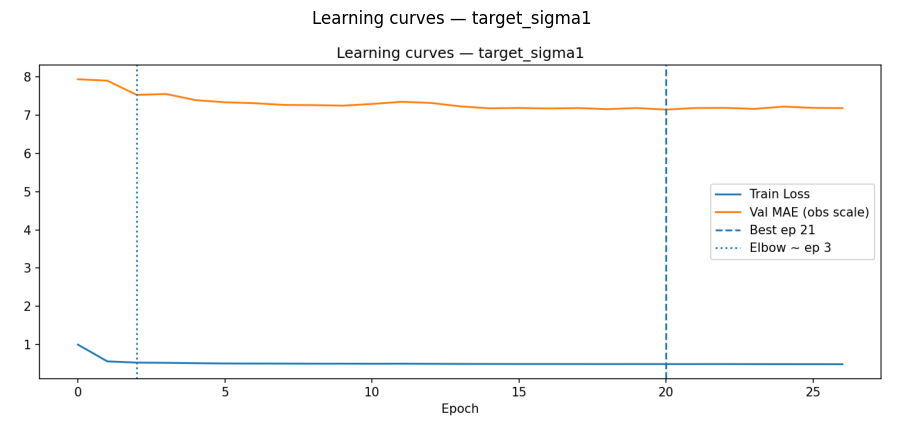

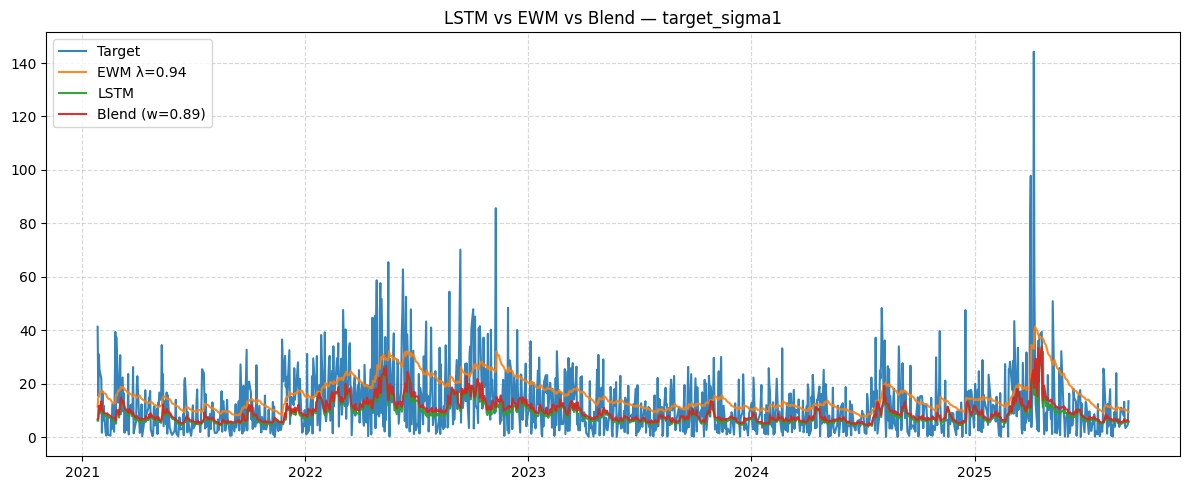

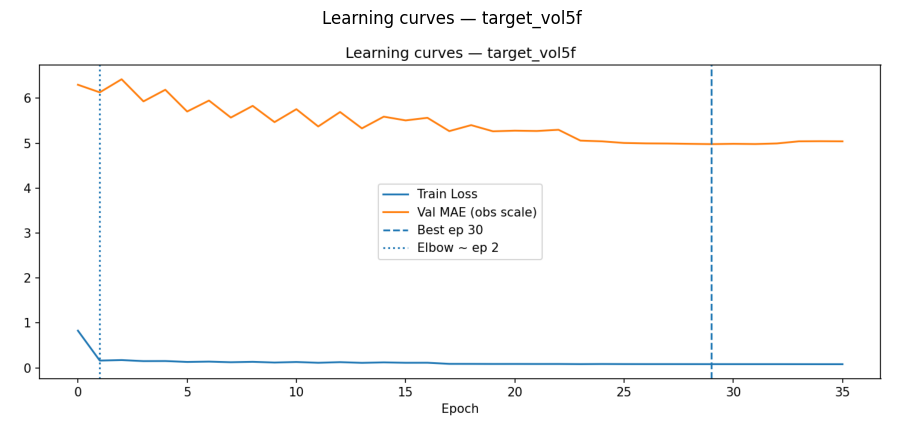

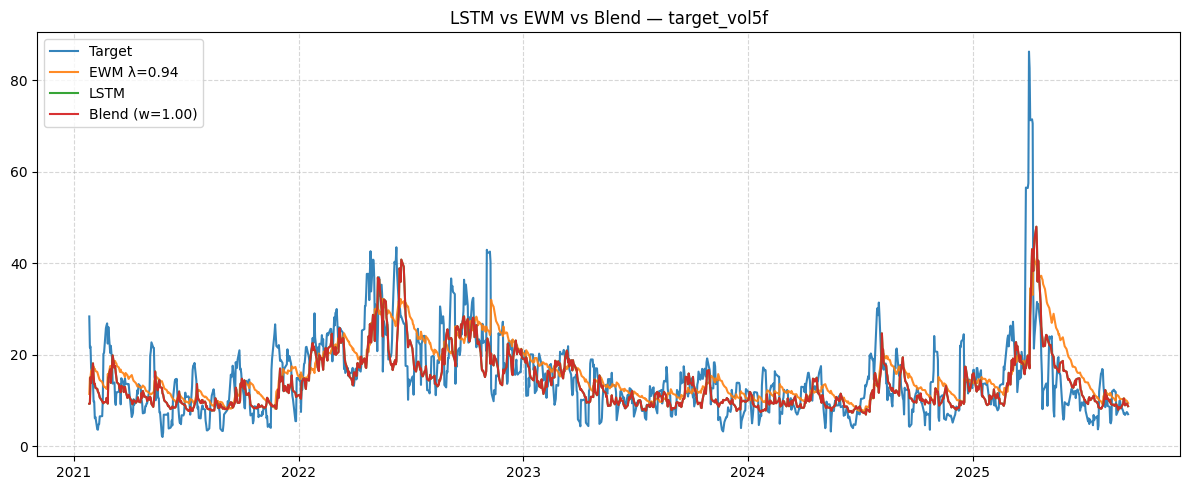

In [ ]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = Path("data/models/lstm")

def _latest_base_for_target(out_dir: Path, target_key: str):
    mets = [p for p in out_dir.glob("*_metrics.json") if target_key in p.name]
    if not mets: return None
    mets.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return mets[0].name.replace("_metrics.json", "")

def _load_run(out_dir: Path, base: str):
    f_metrics = out_dir / f"{base}_metrics.json"
    f_testcsv = out_dir / f"{base}_test.csv"
    f_history = out_dir / f"{base}_history.json"          # optionnel
    f_lc_png  = out_dir / f"{base}_learning_curves.png"   # PNG fallback
    if not (f_metrics.exists() and f_testcsv.exists()):
        return None, None, None, None
    metrics = json.loads(f_metrics.read_text(encoding="utf-8"))
    df_out  = pd.read_csv(f_testcsv, parse_dates=["date"])
    history = json.loads(f_history.read_text(encoding="utf-8")) if f_history.exists() else None
    return metrics, df_out, history, f_lc_png

def _plot_learning_curves(history: dict | None, title: str,
                          best_epoch: int | None, elbow_ep: int | None,
                          fallback_png: Path | None = None):
    # 1) Si on a l'history → on retrace
    if history is not None and (history.get("train_loss") or history.get("val_mae")):
        train_loss = np.asarray(history.get("train_loss", []), dtype=float)
        val_mae    = np.asarray(history.get("val_mae", []), dtype=float)
        plt.figure(figsize=(10, 4.5))
        if len(train_loss): plt.plot(train_loss, label="Train Loss")
        if len(val_mae):    plt.plot(val_mae, label="Val MAE (obs scale)")
        if isinstance(best_epoch, (int, float)):
            plt.axvline(int(best_epoch), ls="--", label=f"Best ep {int(best_epoch)+1}")
        if isinstance(elbow_ep, (int, float)) and elbow_ep and elbow_ep >= 1:
            plt.axvline(int(elbow_ep)-1, ls=":", label=f"Elbow ~ ep {int(elbow_ep)}")
        plt.title(title); plt.xlabel("Epoch"); plt.legend()
        plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()
        return

    # 2) Sinon, fallback : afficher le PNG s'il existe
    if fallback_png is not None and fallback_png.exists():
        img = plt.imread(fallback_png)
        plt.figure(figsize=(10, 4.5))
        plt.imshow(img); plt.axis("off"); plt.title(title)
        plt.tight_layout(); plt.show()
        return

    # 3) Dernier recours : panneau informatif
    plt.figure(figsize=(10, 4.5)); plt.axis("off"); plt.title(title)
    plt.text(0.5, 0.5,
             "Ni history.json ni PNG trouvés pour cette courbe.",
             ha="center", va="center", fontsize=11)
    plt.tight_layout(); plt.show()

def _plot_timeline(df_out: pd.DataFrame, title: str, w_star: float | None):
    required = {"date","y_true","y_lstm","y_ewm"}
    if not required.issubset(df_out.columns):
        plt.figure(figsize=(12, 5)); plt.axis("off"); plt.title(title)
        miss = required - set(df_out.columns)
        plt.text(0.5, 0.5, f"Colonnes manquantes: {sorted(list(miss))}", ha="center", va="center")
        plt.tight_layout(); plt.show(); return

    plt.figure(figsize=(12, 5))
    plt.plot(df_out["date"], df_out["y_true"], label="Target", alpha=0.9)
    plt.plot(df_out["date"], df_out["y_ewm"],  label="EWM λ=0.94", alpha=0.9)
    plt.plot(df_out["date"], df_out["y_lstm"], label="LSTM", alpha=0.95)
    if "y_blend" in df_out.columns:
        label_blend = f"Blend (w={w_star:.2f})" if isinstance(w_star, (int, float)) else "Blend"
        plt.plot(df_out["date"], df_out["y_blend"], label=label_blend, alpha=0.95)
    plt.title(title); plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5); plt.tight_layout(); plt.show()

def show_all_four(out_dir: str | Path = OUT_DIR):
    out_dir = Path(out_dir)

    # --- target_sigma1 ---
    base_sig = _latest_base_for_target(out_dir, "target_sigma1")
    if base_sig is None:
        print("Aucun run trouvé pour target_sigma1.")
    else:
        met_sig, df_sig, hist_sig, lc_sig_png = _load_run(out_dir, base_sig)
        _plot_learning_curves(
            history=hist_sig,
            title="Learning curves — target_sigma1",
            best_epoch=(met_sig.get("best_epoch", 1)-1) if met_sig else None,
            elbow_ep=met_sig.get("elbow_epoch") if met_sig else None,
            fallback_png=lc_sig_png
        )
        _plot_timeline(
            df_out=df_sig if df_sig is not None else pd.DataFrame(),
            title="LSTM vs EWM vs Blend — target_sigma1",
            w_star=met_sig.get("blend_weight_w") if met_sig else None
        )

    # --- target_vol5f ---
    base_v5 = _latest_base_for_target(out_dir, "target_vol5f")
    if base_v5 is None:
        print("Aucun run trouvé pour target_vol5f.")
    else:
        met_v5, df_v5, hist_v5, lc_v5_png = _load_run(out_dir, base_v5)
        _plot_learning_curves(
            history=hist_v5,
            title="Learning curves — target_vol5f",
            best_epoch=(met_v5.get("best_epoch", 1)-1) if met_v5 else None,
            elbow_ep=met_v5.get("elbow_epoch") if met_v5 else None,
            fallback_png=lc_v5_png
        )
        _plot_timeline(
            df_out=df_v5 if df_v5 is not None else pd.DataFrame(),
            title="LSTM vs EWM vs Blend — target_vol5f",
            w_star=met_v5.get("blend_weight_w") if met_v5 else None
        )

# Lance l’affichage
show_all_four()
